# Table of Contents

0. Introduction
   
1. Imbalanced Data
   
2. Imbalanced Data Handling Methods

3. (미완)적용하기 - sol1. over/under sampling

4. (미완)적용하기 - sol2. cost-sensitive learning

# 0. Introduction

**Dataset**  
* [abalone(전복)](https://archive.ics.uci.edu/dataset/1/abalone) | [Download csv file](https://github.com/MyungKyuYi/AI-class/blob/main/abalone.csv)

**Environment**
* macOS `x86`cpu

**Framework**  
* TensorFlow: Version `2.10.0`

**Dependencies**  
* Python: Version `3.9.19`
* Numpy: Version `1.24.3`
* Pandas: Version `2.2.2`
* Matplotlib: Version `3.9.2`
* scikit-learn: Version `1.2.2`

**Purpose**  
* Imbalanced data인 abalone dataset은 각 label에 속하는 data 간의 개수 차이로 인해서 불균형하게 학습하는 문제가 생긴다.
* 위 문제를 해결할 수 있는 방법에 대해서 알아보고, 이를 직접 적용해본다.

**Abstraction**  
Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.  
From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

# 1. Imbalanced Data

> Imbalanced Data Handling의 초점을 맞춘 notebook으로,  
> categorical feature encoding이나 dataset에 대한 sequential-spliting 등의 작업은 별도로 설명하지 않고 진행한다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

2024-09-25 23:17:19.212113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def split_sequences(data, n_steps):
    """
    비연속 데이터셋을 일정한 길이의 연속적인 시퀀스로 변환하는 함수.
    
    Args:
    data: 원본 데이터 (리스트 또는 배열)
    n_steps: 시퀀스의 길이 (정수)
    
    Returns:
    X: 입력 시퀀스
    y: 해당 시퀀스에 대한 다음 값 (타겟 값)
    """
    X, y = [], []
    
    for i in range(len(data)):
        # 데이터의 끝에서 시퀀스 길이 만큼 남은 경우 종료
        end_idx = i + n_steps
        if end_idx > len(data) - 1: break
        
        # 입력 시퀀스와 출력 값(목표값)을 분리
        seq_x, seq_y = data[i:end_idx, :-1], data[end_idx, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [5]:
# Load the dataset
df = pd.read_csv('./datasets/abalone.csv', index_col=0)

# 'Sex' mapping
sex_mapping = {'M': 0, 'F': 1, 'I': 2}
df['Sex'] = df['Sex'].map(sex_mapping)

# 'Rings' mapping(1)
labels = np.unique(df['Rings'], return_counts=True)
rings_mapping = {29: 28}
df['Rings'] = df['Rings'].replace(rings_mapping)
# 'Rings' mapping(2)
rings_mapping = {}
for i in range(len(np.unique(df['Rings']))):
    rings_mapping = {i+1: i}
    df['Rings'] = df['Rings'].replace(rings_mapping)

In [21]:
# Imbalanced Data 확인 - sol1.
labels = np.unique(df['Rings'], return_counts=True)
table = np.transpose(labels)
print("\n[label] [count]")
for row in table:
    print(f"{row[0]:6d} {row[1]:8d}")


[label] [count]
     0        1
     1        1
     2       15
     3       57
     4      115
     5      259
     6      391
     7      568
     8      689
     9      634
    10      487
    11      267
    12      203
    13      126
    14      103
    15       67
    16       58
    17       42
    18       32
    19       26
    20       14
    21        6
    22        9
    23        2
    24        1
    25        1
    26        2
    27        1


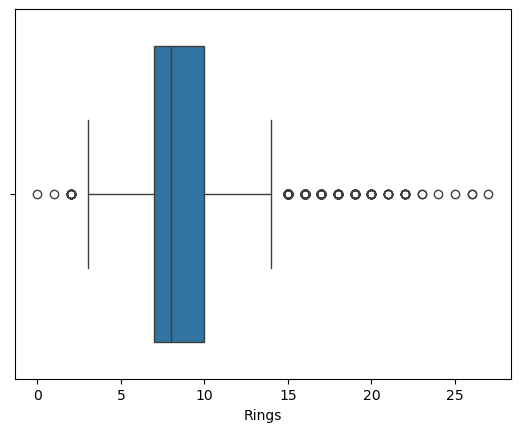

In [24]:
# Imbalanced Data 확인 - sol2.
sns.boxplot(data=df, x='Rings')
plt.show()

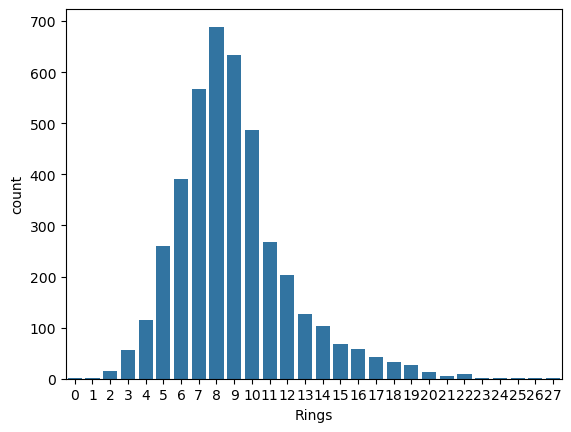

In [27]:
# Imbalanced Data 확인 - sol3.
sns.countplot(data=df, x='Rings')
plt.show()

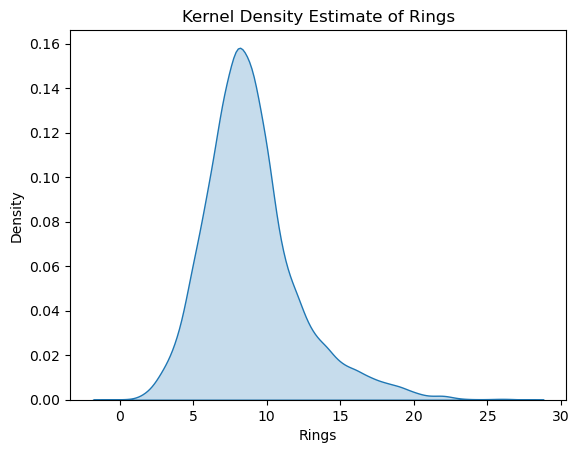

In [28]:
# Imbalanced Data 확인 - sol4. 
sns.kdeplot(df['Rings'], fill=True)
plt.title('Kernel Density Estimate of Rings')
plt.xlabel('Rings')
plt.ylabel('Density')
plt.show()

# 2. Imbalanced Data Handling Methods

먼저 Classification Task 기준으로만 설명함을 알린다.
* * *
Imbalanced Data는 두 가지 방법으로 Handling 할 수 있다.  
1. **Data-level 방법**  
   dataset에서 sample의 수가 불균형한 것을 근본적으로 해결한다.
   * __Under Sampling__  
     다른 label의 sample보다 개수가 많은 label의 sample들 중에서 일부를 제거한다.  
     ex. \[label 0 sample이 1_000개, label 1 sample이 100개\] -> label 0 sample 중 900개 삭제
     > 똑같이 label 0으로 분류된 sample이라고 하더라도 어떤 sample은 label 0이 되기 위한 특징을 너무나도 잘 가지고 있어서 0으로 분류되었을 것이고, 어떤 sample은 얼핏 보면 label 1이라고 착각할 수도 있지만 실제로는 0이라서 0으로 분류된 경우도 있을 것이다.  
     > label 0의 sample들을 무작위로 제거할 때 label 0이 되기 위한 특징을 너무나도 잘 가지고 있는 sample들이 대량으로 제거된다면 model은 label 0이 되기 위한 특징을 제대로 학습하지 못하게 된다.
     > > Random under sampling, CNN, Tomek-link
   * __Over Sampling__  
     다른 label의 sample보다 개수가 적은 label에 대해서 해당 label로 분류될 수 있는 sample들을 추가한다.  
     ex. \[label 0 sample이 500개, label 1 sample이 100개\] -> label 1 sample을 400개 추가
     > 임의로 추가하는 sample을 만드는 방법은 크게 두 가지가 있다.  
     > 하나는 기존의 label 1 sample들을 그대로 복사해서 추가하는 것이고, 다른 하나는 기존의 label 1 sample들 각각의 특성을 조금씩 조합해서 새로운(하지만 기존의 sample들과 매우 유사한) label 1 sample을 만드는 것이다.  
     > 이렇게 되면 결국 label 0에 대해서는 다양한 sample들에게서 다양한 특징을 학습할 수 있지만,  
     > label 1에 대해서는 (매우)비슷비슷한 sample들에게서 비슷한 특징을 학습하게 된다. 따라서 label 1에 대해서 overfitting이 될 수 있다.
     > > Random over sampling, SMOTE(Synthetic Minority Oversampling Technique), Borderline SMOTE
2. **Algorithm-level 방법**  
   소수 label 관측치에 대한 cost값에 가중치를 더 많이 주어 균형 잡힌 학습으로 만드는 방법이다. 다수 클래스보다 소수 클래스 분류에 초점을 둔다.  
   ex. label 0이 100개, label 1이 4개일 때 label 0인 sample을 1이라고 잘못 예측하면 $\frac{1}{100}$ 만큼의 cost를 부과하고, label 1인 sample을 0이라고 잘못 예측하면 $\frac{1}{4}$ 만큼의 cost를 부과한다.  
   > label 0 sample이 96개이고, label 1 sample이 4개라고 하자.  
   > 각 label에 대한 cost가 동일하다면 model은 모든 sample에 대해서 label 0이라고만 예측해도 0.96의 accuracy를 얻게 된다(이해를 더 쉽게 하기 위해서 어쩌다가 label 1 sample 하나는 제대로 예측했다고 하자 -> 전체 정확도 0.97).  
   > 얼핏 보면 되게 잘한 것 같지만 label 1 sample 기준으로 봤을 때는 accuracy가 0.25에 불과하다.  
   > 만약 classification task가 '마약 검사'인 경우에는 매우 형편없는 모델이 된다.  
   > 우리가 제대로 classify 하기 원하는 것은 label 0(마약 안 함)의 사람이 아니라, label 1(마약 함)의 사람이다.

# 3. 개선하기

예, 예측 값이 실제 레이블 분포보다 좁은 범위에 집중되는 문제를 해결하기 위해 다음과 같은 방법을 시도할 수 있습니다:

1. **데이터 불균형 문제 해결**: 레이블의 분포가 불균형하다면, 모델은 빈도가 높은 중간 값에 집중하여 예측하는 경향이 있습니다. 이를 해결하기 위해 언더샘플링이나 오버샘플링을 통해 데이터의 균형을 맞출 수 있습니다. 특히 **Synthetic Minority Over-sampling Technique (SMOTE)**와 같은 기법을 사용하면 소수 클래스의 데이터를 인위적으로 생성하여 불균형을 완화할 수 있습니다.

2. **가중 손실 함수 사용**: 손실 함수에 가중치를 부여하여 희귀한 레이블 값에 대한 오류에 더 큰 페널티를 줄 수 있습니다. 이를 통해 모델이 다양한 레이블 값을 예측하는 데 집중하도록 유도할 수 있습니다.

3. **데이터 변환 및 정규화**: 레이블 값의 분포를 정규화하거나 변환(예: 로그 변환)하여 모델이 극단값을 더 잘 학습할 수 있게 합니다.

~4. **모델 아키텍처 조정**: CNN 이외에도 다른 모델이나 하이브리드 모델을 사용해 볼 수 있습니다. 예를 들어, **회귀 문제에 특화된 모델**이나 **시계열 데이터를 다루는 모델**을 적용하여 성능을 향상시킬 수 있습니다.~

~5. **앙상블 기법 적용**: 여러 모델의 예측 결과를 결합하여 일반화 능력을 향상시킬 수 있습니다. 이것은 예측 값의 다양성을 증가시키는 데 도움이 됩니다.~

~6. **특징 공학 개선**: 중요한 특징을 추가하거나 불필요한 특징을 제거하여 데이터의 표현력을 높입니다. 도메인 지식을 활용하여 새로운 파생 변수를 만들 수도 있습니다.~

7. **학습률 및 하이퍼파라미터 조정**: 학습률, 배치 크기, 에폭 수 등 하이퍼파라미터를 조정하여 모델의 학습 과정을 최적화할 수 있습니다.

~8. **조기 종료 및 정규화 기법 사용**: **과적합(overfitting)**을 방지하기 위해 조기 종료, 드롭아웃(dropout), 가중치 감쇠(weight decay) 등의 정규화 기법을 사용할 수 있습니다.~

~9. **교차 검증 활용**: 교차 검증을 통해 모델의 일반화 성능을 평가하고 개선점을 찾을 수 있습니다.~

위의 방법들을 조합하여 적용하면 모델이 레이블 분포 전체에 걸쳐 보다 정확한 예측을 수행할 가능성이 높아집니다. 특히 데이터의 불균형 문제가 원인이라면 이를 우선적으로 해결하는 것이 중요합니다.

## 3.1. 레이블 분포에 따른 가중 손실 함수 사용

In [32]:
import numpy as np

# 레이블을 일정한 구간으로 나누기
num_bins = 10  # 원하는 구간 수로 설정하세요
bins = np.linspace(y_train_seq.min(), y_train_seq.max(), num_bins + 1)
y_binned = np.digitize(y_train_seq, bins) - 1  # 인덱스가 0부터 시작하도록 조정

# 구간별 빈도수 계산
bin_counts = np.bincount(y_binned)
total_samples = len(y_train_seq)
bin_frequencies = bin_counts / total_samples

# 빈도에 따라 가중치 계산 (너무 큰 가중치를 방지하기 위해 제곱근 또는 로그를 사용)
# 예: 빈도수의 역수의 제곱근을 사용
bin_weights = 1.0 / np.sqrt(bin_frequencies)

# 가중치 정규화 (평균을 1로 맞춤)
bin_weights = bin_weights / np.mean(bin_weights)

# 각 샘플에 대한 가중치 배열 생성
sample_weights = bin_weights[y_binned]

In [33]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'],
              weighted_metrics=['mean_squared_error'])

In [34]:
history2 = model.fit(X_train_seq, y_train_seq,
                     sample_weight=sample_weights,
                     validation_split=0.1,
                     epochs=epochs,
                     batch_size=32,
                     shuffle=True,
                     verbose=2)

Epoch 1/50
88/88 - 1s - loss: 4.0748 - mean_squared_error: 12.6329 - weighted_mean_squared_error: 26.0273 - val_loss: 1.7728 - val_mean_squared_error: 9.8349 - val_weighted_mean_squared_error: 12.7135 - 752ms/epoch - 9ms/step
Epoch 2/50
88/88 - 0s - loss: 3.8200 - mean_squared_error: 12.2008 - weighted_mean_squared_error: 24.3994 - val_loss: 1.7944 - val_mean_squared_error: 10.5191 - val_weighted_mean_squared_error: 12.8688 - 112ms/epoch - 1ms/step
Epoch 3/50
88/88 - 0s - loss: 3.8284 - mean_squared_error: 12.4389 - weighted_mean_squared_error: 24.4529 - val_loss: 1.8657 - val_mean_squared_error: 9.7345 - val_weighted_mean_squared_error: 13.3797 - 106ms/epoch - 1ms/step
Epoch 4/50
88/88 - 0s - loss: 3.8709 - mean_squared_error: 12.6906 - weighted_mean_squared_error: 24.7249 - val_loss: 1.8125 - val_mean_squared_error: 10.8385 - val_weighted_mean_squared_error: 12.9984 - 105ms/epoch - 1ms/step
Epoch 5/50
88/88 - 0s - loss: 3.6633 - mean_squared_error: 12.0781 - weighted_mean_squared_err

In [35]:
# evaluate the model - train

y_preds_train = model(X_train_seq)
print(f"MSE(train): {mean_squared_error(y_preds_train, y_train_seq)}")

MSE(train): 10.506194865870754


In [36]:
# evaluate the model - test

y_preds_test = model(X_test_seq)
print(f"MSE(test): {mean_squared_error(y_preds_test, y_test_seq)}")

MSE(test): 15.605061100943459


* * *

In [37]:
from sklearn.utils import class_weight

sample_weights = class_weight.compute_sample_weight('balanced', y_train_seq)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'],
              weighted_metrics=['mean_squared_error'])

In [38]:
history3 = model.fit(X_train_seq, y_train_seq,
                     sample_weight=sample_weights,
                     validation_split=0.1,
                     epochs=epochs,
                     batch_size=32,
                     shuffle=True,
                     verbose=2)

Epoch 1/50
88/88 - 1s - loss: 24.4388 - mean_squared_error: 18.7862 - weighted_mean_squared_error: 23.3146 - val_loss: 16.0540 - val_mean_squared_error: 25.7687 - val_weighted_mean_squared_error: 28.3385 - 691ms/epoch - 8ms/step
Epoch 2/50
88/88 - 0s - loss: 22.7138 - mean_squared_error: 21.1769 - weighted_mean_squared_error: 21.6689 - val_loss: 15.0847 - val_mean_squared_error: 24.5503 - val_weighted_mean_squared_error: 26.6275 - 110ms/epoch - 1ms/step
Epoch 3/50
88/88 - 0s - loss: 26.6209 - mean_squared_error: 19.6184 - weighted_mean_squared_error: 25.3963 - val_loss: 16.0835 - val_mean_squared_error: 26.4220 - val_weighted_mean_squared_error: 28.3906 - 126ms/epoch - 1ms/step
Epoch 4/50
88/88 - 0s - loss: 24.6760 - mean_squared_error: 20.8132 - weighted_mean_squared_error: 23.5409 - val_loss: 14.5512 - val_mean_squared_error: 20.6743 - val_weighted_mean_squared_error: 25.6858 - 101ms/epoch - 1ms/step
Epoch 5/50
88/88 - 0s - loss: 20.2322 - mean_squared_error: 18.0042 - weighted_mean_

In [39]:
# evaluate the model - train

y_preds_train = model(X_train_seq)
print(f"MSE(train): {mean_squared_error(y_preds_train, y_train_seq)}")

# evaluate the model - test

y_preds_test = model(X_test_seq)
print(f"MSE(test): {mean_squared_error(y_preds_test, y_test_seq)}")

MSE(train): 14.574323664482737
MSE(test): 22.800743815478718


## 3.2. 언더샘플링 & 오버샘플링

['<label count>',
 'Rings  count',
 '    1      1',
 '    2      1',
 '    3     15',
 '    4     57',
 '    5    115',
 '    6    259',
 '    7    391',
 '    8    568',
 '    9    689',
 '   10    634',
 '   11    487',
 '   12    267',
 '   13    203',
 '   14    126',
 '   15    103',
 '   16     67',
 '   17     58',
 '   18     42',
 '   19     32',
 '   20     26',
 '   21     14',
 '   22      6',
 '   23      9',
 '   24      2',
 '   25      1',
 '   26      1',
 '   27      2',
 '   29      1']

현재 df['Rings']에 대한 label이 이렇게 분포되어 있는데 지금 count가 30 이하인 애들은 30으로 오버샘플링하고, count가 100 이상인 애들은 60으로 언더샘플링 하고싶어.

알겠습니다. 제공해주신 레이블 분포를 기반으로, 다음과 같은 방식으로 오버샘플링과 언더샘플링을 수행하고자 하시는군요:

- 카운트가 30 이하인 레이블: 샘플 수를 30으로 오버샘플링합니다.
- 카운트가 100 이상인 레이블: 샘플 수를 60으로 언더샘플링합니다.
- 카운트가 31 이상 99 이하인 레이블: 기존의 샘플 수를 그대로 유지합니다.

이제 이를 구현하기 위한 코드를 단계별로 제공해 드리겠습니다.

In [ ]:
# 레이블별로 그룹화
groups = df.groupby('Rings')

# 레이블별 샘플 수 출력
label_counts = df['Rings'].value_counts().sort_index()
print(label_counts)

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 특징 스케일링 (학습 데이터 기준)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# SMOTER 인스턴스 생성
oversampler = sv.SMOTER()

# 오버샘플링 적용
X_resampled, y_resampled = oversampler.sample(X_train_scaled, y_train)

In [ ]:
# 샘플링된 데이터를 담을 리스트 초기화
sampled_dfs = []

# SMOTER를 적용하기 위해 데이터프레임 생성
data = df.copy()

# 데이터 셔플
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# 데이터 분할
under_sampled_data = pd.DataFrame()
smoter_data_X = pd.DataFrame()
smoter_data_y = pd.Series()

for label, group in data.groupby('Rings'):
    count = len(group)
    if count < 150:
        # 오버샘플링 대상 (SMOTER 적용을 위해 나중에 처리)
        smoter_data_X = pd.concat([smoter_data_X, group[features]], axis=0)
        smoter_data_y = pd.concat([smoter_data_y, group['Rings']], axis=0)
    elif count > 150:
        # 언더샘플링
        group_sampled = resample(group,
                                 replace=False,  # 비복원 추출
                                 n_samples=150,
                                 random_state=42)
        under_sampled_data = pd.concat([under_sampled_data, group_sampled], axis=0)
        print(f"Label {label}: Undersampled from {count} to 150 samples.")
    else:
        # 그대로 사용
        under_sampled_data = pd.concat([under_sampled_data, group], axis=0)
        print(f"Label {label}: Kept original {count} samples.")

In [ ]:
# SMOTER를 적용하기 전에 특징(feature) 스케일링
scaler = StandardScaler()
smoter_data_X_scaled = scaler.fit_transform(smoter_data_X)

# SMOTER 인스턴스 생성
smoter = SMOTER(k_neighbors=5, random_state=42)

# SMOTER를 적용하여 오버샘플링 (X는 스케일된 데이터, y는 원본)
X_resampled, y_resampled = smoter.fit_resample(smoter_data_X_scaled, smoter_data_y)

# 결과를 데이터프레임으로 변환
smoter_resampled_df = pd.DataFrame(X_resampled, columns=features)
smoter_resampled_df['Rings'] = y_resampled

# 오버샘플링 후 각 레이블별로 150개로 맞춤
final_oversampled_groups = []
for label, group in smoter_resampled_df.groupby('Rings'):
    count = len(group)
    if count > 150:
        # 오버샘플링 후 샘플 수가 150개 초과하면 언더샘플링
        group_sampled = group.sample(n=150, random_state=42)
        final_oversampled_groups.append(group_sampled)
        print(f"Label {label}: Oversampled using SMOTER and undersampled to 150 samples.")
    elif count < 150:
        # 오버샘플링 후에도 샘플 수가 150개 미만인 경우 (드물게 발생할 수 있음)
        group_sampled = group.sample(n=150, replace=True, random_state=42)
        final_oversampled_groups.append(group_sampled)
        print(f"Label {label}: Oversampled using SMOTER and further oversampled to 150 samples.")
    else:
        # 샘플 수가 150개인 경우
        final_oversampled_groups.append(group)
        print(f"Label {label}: Oversampled using SMOTER to 150 samples.")

# 오버샘플링된 그룹 병합
oversampled_data = pd.concat(final_oversampled_groups, axis=0)

In [ ]:
# 언더샘플링된 데이터와 오버샘플링된 데이터 병합
balanced_df = pd.concat([under_sampled_data, oversampled_data], axis=0)

# 데이터 셔플 및 인덱스 리셋
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
X = balanced_df[features].values
y = balanced_df['Rings'].values

# 전체 데이터를 학습용과 테스트용으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 특징 스케일링 (학습 데이터 기준으로 스케일러 다시 학습)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# X와 y를 하나로 합친 dataset 만들기
# 합치기 위해서는 y도 2dim으로 변경해줘야됨 by reshape()
train_set = np.c_[X_train_scaled, y_train.reshape(-1, 1)]
test_set = np.c_[X_test_scaled, y_test.reshape(-1, 1)]

print(f"train_set.head(): \n{train_set[:5]}")

In [ ]:
# Sequential dataset 만들기
n_steps = 5 # 전복 5마리를 한 개의 set으로 묶기
X_train_seq, y_train_seq = split_sequences(train_set,
                                           n_steps)

X_test_seq, y_test_seq = split_sequences(test_set,
                                         n_steps)

print(f"X_train_seq.shape: {X_train_seq.shape}", end=" ")
print(f"y_train_seq.shape: {y_train_seq.shape}")
print(f"X_test_seq.shape: {X_test_seq.shape}", end=" ")
print(f"y_test_seq.shape: {y_test_seq.shape}")

In [ ]:
n_steps = X_train_seq.shape[1]
features = X_train_seq.shape[2]

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

# Create the model
model = keras.models.Sequential()

# Add the layers to model
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=64,
                               kernel_size=3,
                               activation='relu',
                               input_shape=(n_steps, features),
                               name='conv1d'))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(units=128,
                              activation='relu',
                              name='dense1'))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=1,
                              name='output'))

model.summary()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

In [ ]:
epochs = 50
history = model.fit(X_train_seq, y_train_seq,
                    batch_size=32,
                    validation_split=0.1,
                    shuffle=True,
                    verbose=2,
                    epochs=epochs)

In [ ]:
# evaluate the model - test
from sklearn.metrics import mean_squared_error

y_preds_test = model(X_test_seq)
print(f"MSE(test): {mean_squared_error(y_preds_test, y_test_seq)}")

In [ ]:
preds = model(X_train_seq)
for pred in preds:
    print(pred)

In [ ]:
# label 확인
labels = np.unique(balanced_df['Rings'], return_counts=True)
print("\n<label count>")
table = np.vstack(labels).T
print("Rings  count")
for row in table:
    print(f"{row[0]:5d} {row[1]:6d}")

# problem 1. label이 0부터 시작하지 않는다.
# problem 2. label에 빈 공간이 있다(28).

In [ ]:
sns.kdeplot(balanced_df['Rings'], fill=True)
plt.title('Kernel Density Estimate of Rings')
plt.xlabel('Rings')
plt.ylabel('Density')
plt.show()

# labeling bias 때문인지 전부 다 8 ~ 11로 예측해버림